In [41]:
#importing libraries
import requests
from bs4 import BeautifulSoup
import time
import re
import pandas as pd
from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.common.by import By
import matplotlib as plt

In [142]:
#starting new browser
driver = webdriver.Chrome() # Use driver = webdriver.Chrome(“Path to executable”) if Selenium is unable to identify the Chrome driver executable
url = "https://www.vivino.com/explore"
driver.get(url)

In [43]:
#accepting cookies
driver.find_element(By.XPATH,'//*[@id="didomi-notice-agree-button"]').click()

In [44]:
#using beautiful soup to count number of wines displayed
soup = BeautifulSoup(driver.page_source, "html.parser")
list_of_wines = soup.find_all("div", class_="wineCard__wineCard--2dj2T")
print(len(list_of_wines))

25


In [74]:
#testing scraping methods for new variables
list_of_wines[0].find('div',class_ = re.compile('vivinoRating_averageValue__*')).text


if list_of_wines[1].find('span', class_ = re.compile('price_strike.*')) == None:
    print('hi')

re.findall(r'\b\d+\b',list_of_wines[0].find('div',class_ = re.compile('vivinoRating_caption__.*')).text)


hi


In [78]:
#gathering data for name, price, undiscounted price, average rating, number of raters
wine_data = {'names':[],'prices':[], 'undiscounted':[],'rating':[],'numberOfRaters':[]}
for wine in list_of_wines:
    wine_data['names'].append(wine.find('div',class_ = re.compile('wineInfoVintage__vintage.*')).text)
    price_tag = wine.find('div',class_ = re.compile('addToCartButton__price.*'))
    wine_data['prices'].append(price_tag.find_all('div')[1].text)
    if wine.find('span',class_ = re.compile('price_strike.*')) == None:
        wine_data['undiscounted'].append('None')
    else:
        wine_data['undiscounted'].append(wine.find('span',class_ = re.compile('price_strike.*')).text)
    wine_data['rating'].append(wine.find('div',class_ = re.compile('vivinoRating_averageValue__*')).text)
    wine_data['numberOfRaters'].append(re.findall(r'\b\d+\b',(wine.find('div',class_ = re.compile('vivinoRating_caption__.*')).text)))
print(pd.DataFrame(wine_data))

                                                names prices undiscounted  \
0                 Bellafiore Rosso delle Venezie 2019  11.95       £13.95   
1                               Queirón Mi Lugar 2018  24.95         None   
2               Amaranta Montepulciano d'Abruzzo 2020  21.99         None   
3                              Celsole Primitivo 2022  16.95         None   
4   Durigutti Proyecto Las Compuertas Malbec 5 Sue...  22.91       £26.95   
5                           Lourens River Valley 2016  24.61       £28.95   
6                                    Donatus Red 2018  20.95       £24.65   
7                                   Grand Malbec 2019  24.99         None   
8                         Neropasso Veneto Rosso 2020  11.95         None   
9                        Cuvée Tradition Fronsac 2018  14.36       £17.95   
10                                    Haut-Médoc 2018  17.81       £20.95   
11                             Dominio de Taurum 2020  14.41       £16.95   

## Describe why you would collect this data in the context of identifying arbitrage opportunities:

Using the discounted prices and normal prices, one could compare these selling prices to competing wine selling websites and in situations where the discounted price is far below the average market price, one could set up an abritrage situation where one buys from vivino and resells on open market websites like amazon at a profit. Additionally, using a metric that factors in the number of reviews and the total review score, you would be able to know which wines are the most popular and are the the most favored. Knowing which are the most popular wines will allow you to help focus your reselling business to focus on high volume products

In [152]:
  #limiting the number of page scrolls to 20 in order to prevent timeout error in the function 

In [167]:
#creating a scraping function
#url - type in the url website 
#rating - 1 for top rating 2 for 2nd tier rating
#type of wine - red for red and white for white 
def extract_wine_data(url,rating,type_wine):
    
    driver = webdriver.Chrome() 
    driver.get(url)

    #accepting cookies
    driver.find_element(By.XPATH,'//*[@id="didomi-notice-agree-button"]').click()
    
    #add in the rating 
    rating_labs = driver.find_element(By.XPATH,'//div[contains(@class,"filterByRating")]')
    rating_labs.find_element(By.XPATH,f'.//label[{rating}]').click()
    
    #add in type of wine
    if type_wine == 'white':
        type_labs = driver.find_element(By.XPATH,'//div[contains(@class,"filterByWineType")]')
        type_labs.find_element(By.XPATH,f'.//label[1]').click()
        type_labs.find_element(By.XPATH,f'.//label[2]').click()
    
    
    #scrolling to the bottom
    last_height = driver.execute_script("return document.body.scrollHeight")
    
    #limiting the number of page scrolls to 20 in order to prevent timeout error
    for i in range(20):
    # scrolling down to the bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1.5)
    # extracting new scroll height and comparing with the last scroll height (if no difference, stop the function)
        new_height = driver.execute_script("return document.body.scrollHeight")

        if new_height == last_height:
            break
        last_height = new_height

     #using beautiful soup to get wines
    soup = BeautifulSoup(driver.page_source, "html.parser")
    list_of_wines = soup.find_all("div", class_="wineCard__wineCard--2dj2T")
    
    
    wine_data = {'names':[], 'prices':[], 'undiscounted':[], 'rating':[], 'numberOfRaters':[]}

    for wine in list_of_wines:
        wine_data['names'].append(wine.find('div', class_=re.compile('wineInfoVintage__vintage.*')).text)
        price_tag = wine.find('div', class_=re.compile('addToCartButton__price.*'))
        wine_data['prices'].append(price_tag.find_all('div')[1].text)
        
        if wine.find('span', class_=re.compile('price_strike.*')) is None:
            wine_data['undiscounted'].append('None')
        else:
            wine_data['undiscounted'].append(wine.find('span', class_=re.compile('price_strike.*')).text)
        
        wine_data['rating'].append(wine.find('div', class_=re.compile('vivinoRating_averageValue__.*')).text)
        
        # Extracting the number of raters and converting it to an integer
        raters_text = wine.find('div', class_=re.compile('vivinoRating_caption__.*')).text
        num_raters = re.findall(r'\b\d+\b', raters_text)
        if num_raters:
            wine_data['numberOfRaters'].append(int(num_raters[0]))
        else:
            wine_data['numberOfRaters'].append(0)
            
      
    if 'driver' in locals():
        driver.quit()

    return pd.DataFrame(wine_data)

In [156]:
#red wine with top rating 
red_top = extract_wine_data("https://www.vivino.com/explore",1,'red')
red_top

,names,prices,undiscounted,rating,numberOfRaters
0,Queirón Mi Lugar 2018,24.95,None,4.3,1032
1,Bellafiore Rosso delle Venezie 2019,11.95,£13.95,4.3,321
2,Amaranta Montepulciano d'Abruzzo 2020,21.99,None,4.3,822
3,Celsole Primitivo 2022,16.95,None,4.2,38
4,Durigutti Proyecto Las Compuertas Malbec 5 Sue...,22.91,£26.95,4.2,25
...,...,...,...,...,...
179,Reserve Petit Verdot 2018,19,None,4.2,91
180,Shiraz 2020,17.94,None,4.2,281
181,Stilio Primitivo di Manduria 2021,22.99,None,4.2,2137
182,Caro Maestro 2018,24.50,None,4.2,56


In [120]:
#red wine with second rating
red_second = extract_wine_data("https://www.vivino.com/explore",2,'red')

In [130]:
red_second

,names,prices,undiscounted,rating,numberOfRaters
0,Bellafiore Rosso delle Venezie 2019,11.95,£13.95,4.3,321
1,Queirón Mi Lugar 2018,24.95,None,4.3,1032
2,Amaranta Montepulciano d'Abruzzo 2020,21.99,None,4.3,822
3,Celsole Primitivo 2022,16.95,None,4.2,38
4,Durigutti Proyecto Las Compuertas Malbec 5 Sue...,22.91,£26.95,4.2,25
...,...,...,...,...,...
370,Punta Aquila Primitivo 2020,17.30,None,4.1,135
371,Santagostino Baglio Sorìa Red 2018,21.90,None,4.1,113
372,Chianti Classico 2021,24.30,None,4.1,271
373,Maroccoli Syrah 2019,23.80,None,4.1,115


In [157]:
#removing all duplicate values from top rated red wines. the first 183 rows which are top rated
red_second_clean = red_second.iloc[183:].reset_index(drop = True)

In [158]:
red_second_clean

,names,prices,undiscounted,rating,numberOfRaters
0,Imagínate El Vino 2019,24.18,None,4.2,132
1,Caro Maestro 2018,24.50,None,4.2,56
2,Parcela #7 Gran Reserva 2019,23.50,None,4.2,413
3,Seismic 2020,16.95,None,4.2,174
4,Reserva 2016,21.99,None,4.2,131
...,...,...,...,...,...
187,Punta Aquila Primitivo 2020,17.30,None,4.1,135
188,Santagostino Baglio Sorìa Red 2018,21.90,None,4.1,113
189,Chianti Classico 2021,24.30,None,4.1,271
190,Maroccoli Syrah 2019,23.80,None,4.1,115


In [168]:
#white wine with top rating 
white_top = extract_wine_data("https://www.vivino.com/explore",1,'white')

In [169]:
white_top

,names,prices,undiscounted,rating,numberOfRaters
0,Queirón Mi Lugar 2018,24.95,None,4.3,1032
1,Bellafiore Rosso delle Venezie 2019,11.95,£13.95,4.3,321
2,Amaranta Montepulciano d'Abruzzo 2020,21.99,None,4.3,822
3,Celsole Primitivo 2022,16.95,None,4.2,38
4,Durigutti Proyecto Las Compuertas Malbec 5 Sue...,22.91,£26.95,4.2,25
...,...,...,...,...,...
132,Valencay 2021,15.31,None,4.2,45
133,Les Trois Schistes Côteaux de l'Aubance 2018,24.95,None,4.2,53
134,Clos de la Thibaudière Saumur Blanc 2013,24,None,4.2,39
135,Weiss 2020,24.21,None,4.2,299


In [170]:
#white wine with top rating 
white_second = extract_wine_data("https://www.vivino.com/explore",2,'white')

In [171]:
white_second

,names,prices,undiscounted,rating,numberOfRaters
0,Queirón Mi Lugar 2018,24.95,None,4.3,1032
1,Bellafiore Rosso delle Venezie 2019,11.95,£13.95,4.3,321
2,Amaranta Montepulciano d'Abruzzo 2020,21.99,None,4.3,822
3,Celsole Primitivo 2022,16.95,None,4.2,38
4,Durigutti Proyecto Las Compuertas Malbec 5 Sue...,22.91,£26.95,4.2,25
...,...,...,...,...,...
520,Torre de Vila Nova Vinho Verde 2022,10.97,None,4.0,47
521,Sauvignon Blanc 2021,12.24,None,4.0,102
522,Sancerre Silex 2022,24.86,None,4.0,600
523,Pinot Gris Alsace Grand Cru Brand 2017,19.84,None,4.0,317


In [172]:
#removing the first 136 rows which are top rated whites
white_second_clean = white_second.iloc[136:].reset_index(drop = True)

In [173]:
white_second_clean

,names,prices,undiscounted,rating,numberOfRaters
0,Bortolo Vigne Vecchie Soave Classico 2017,19.75,None,4.2,125
1,Tokaji Szamorodni 2019,14.99,None,4.2,25
2,La Collection Côtes de Thau Blanc 2021,20.52,None,4.2,90
3,Valencay 2021,15.31,None,4.2,45
4,Les Trois Schistes Côteaux de l'Aubance 2018,24.95,None,4.2,53
...,...,...,...,...,...
384,Torre de Vila Nova Vinho Verde 2022,10.97,None,4.0,47
385,Sauvignon Blanc 2021,12.24,None,4.0,102
386,Sancerre Silex 2022,24.86,None,4.0,600
387,Pinot Gris Alsace Grand Cru Brand 2017,19.84,None,4.0,317


In [186]:
#converting all prices and ratings to numbers
red_top['prices'] = red_top['prices'].astype(float)
red_second_clean['prices'] = red_second_clean['prices'].astype(float)
white_top['prices'] = white_top['prices'].astype(float)
white_second_clean['prices'] = white_second_clean['prices'].astype(float)
red_top['rating'] = red_top['rating'].astype(float)
red_second_clean['rating'] = red_second_clean['rating'].astype(float)
white_top['rating'] = white_top['rating'].astype(float)
white_second_clean['rating'] = white_second_clean['rating'].astype(float)

<Axes: title={'center': 'prices'}>

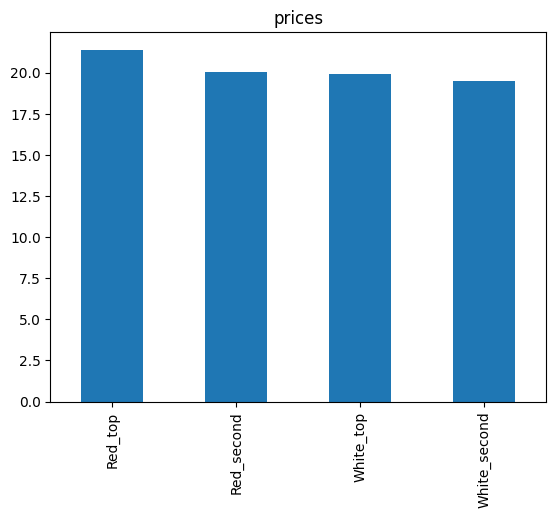

In [187]:
plotdata = pd.DataFrame({'prices':[red_top['prices'].mean(),red_second_clean['prices'].mean(),white_top['prices'].mean(),white_second_clean['prices'].mean()]},index=['Red_top','Red_second','White_top','White_second'])
plotdata['prices'].plot(kind='bar', title='prices')

<Axes: title={'center': 'rating'}>

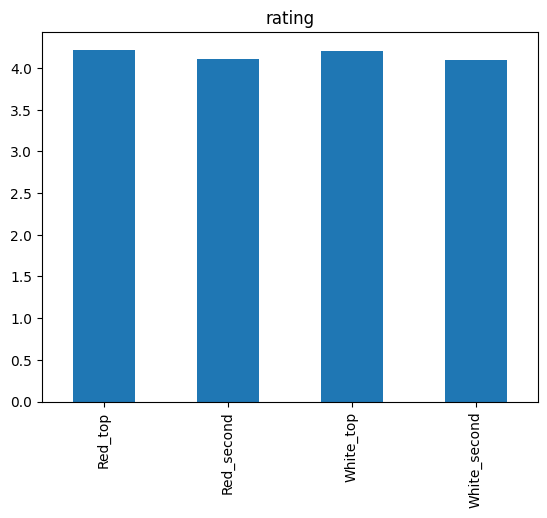

In [188]:
plotdata = pd.DataFrame({'rating':[red_top['rating'].mean(),red_second_clean['rating'].mean(),white_top['rating'].mean(),white_second_clean['rating'].mean()]},index=['Red_top','Red_second','White_top','White_second'])
plotdata['rating'].plot(kind='bar', title='rating')

<Axes: title={'center': 'numberOfRaters'}>

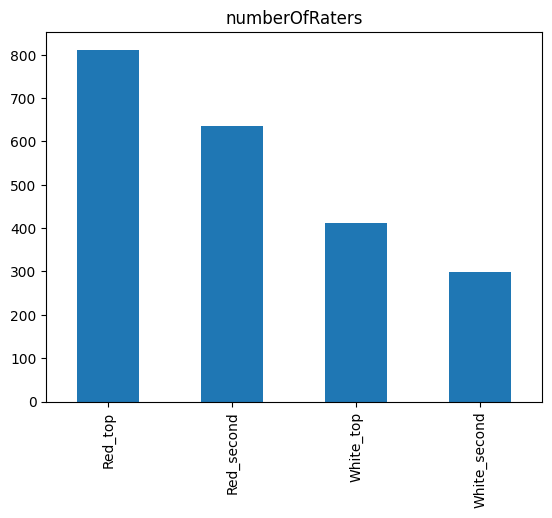

In [189]:
plotdata = pd.DataFrame({'numberOfRaters':[red_top['numberOfRaters'].mean(),red_second_clean['numberOfRaters'].mean(),white_top['numberOfRaters'].mean(),white_second_clean['numberOfRaters'].mean()]},index=['Red_top','Red_second','White_top','White_second'])
plotdata['numberOfRaters'].plot(kind='bar', title='numberOfRaters')

Top red wines are the most expensive followed by second tier red wines, top white wines and lastky second tier white wines.

All wines have a similiar rating, with the top wines having a slightly average rating.

Red wines are by far the most bought and hence the most rated wines. 
